In [1]:
import pandas as pd
import os
os.chdir(os.path.dirname(os.getcwd()))
import numpy as np
from datetime import datetime,date
from dateutil import relativedelta
import matplotlib.pyplot as plt
import copy
%load_ext autoreload
%autoreload 2
from src.data import preprocessing
import pickle as pkl

In [2]:
path_data = '\\StorageOptimization\\data\\raw\\Data1.xlsx'
raw_data = os.getcwd() + path_data

gas_data = preprocessing.prepare_data(raw_data)

Trying to load data from cache...
Loaded data from cache.
Here are the names of the worksheets:
Notes Grunddata GPN WD TTF Gaspool NCG Weather forecast Weather observations


In [3]:
gas_data['Notes']

,Sheet,Description,Unnamed: 2,Markets,Unnamed: 4
0,Grunddata:,Prices for DayAhead and Weekends on all 4 rele...,NaN,GPL,Gaspool (Germany)
1,NaN,Includes Monthly Index,NaN,NCG,NetConnectGermany
2,GPN WD,Within Day prices DK,NaN,TTF,TitleTransferFacility (Holland)
3,"TTF, Gaspool, NCG",Prices for future contracts,NaN,GPN,GasPointNodic (Denmark)
4,Weather forecast,Self explanatory,NaN,NaN,NaN
5,Weather observations,Self explanatory,NaN,DMIFilesID,Area
6,NaN,NaN,NaN,1,KBH
7,NaN,NaN,NaN,2,MJYL
8,NaN,NaN,NaN,3,NJYL
9,NaN,NaN,NaN,4,FYN


# Forecasting the gas prices

In [4]:
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.api as sm
import itertools

In [5]:
gas_data['Grunddata']

,Month,Quote date,Delivery date,Periode,Dag,TTF Bid,TTF offer,TTF Mid,TTF Heren day-ahead+Spot weekend Index,TTF Heren Monthly Index,...,NCG Heren Mid,NCG Heren day-ahead + spot weekend Index,NCG Heren Monthly Index,NCG eex,Gaspool Bid,Gaspool Offer,Gaspool Mid,Gaspool Heren day-ahead + spot weekend Index,GPN,GPN month-ahead
0,1,2011-12-30,2012-01-01,Day-ahead,Sunday,20.000,20.100,20.050,20.079,23.139,...,20.400,20.725,23.169,20.500,20.600,21.100,20.850,NaN,22.570,23.737
1,1,2011-12-30,2012-01-02,Day-ahead,Monday,20.000,20.100,20.050,20.079,23.139,...,20.400,20.725,23.169,21.300,20.600,21.100,20.850,NaN,22.970,23.737
2,1,2011-12-30,2012-01-03,Day-ahead,Tuesday,21.000,21.100,21.050,21.023,23.139,...,21.375,21.305,23.169,20.300,21.575,21.625,21.600,NaN,22.790,23.737
3,1,2012-01-03,2012-01-04,Day-ahead,Wednesday,20.750,20.800,20.775,21.170,23.139,...,21.200,21.411,23.169,21.050,21.100,21.300,21.200,NaN,21.880,23.737
4,1,2012-01-04,2012-01-05,Day-ahead,Thursday,21.300,21.350,21.325,21.234,23.139,...,21.550,21.461,23.169,21.390,21.300,21.500,21.400,NaN,21.800,23.737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2744,7,2019-07-05,2019-07-07,Day-ahead,Sunday,10.975,11.000,10.988,10.259,NaN,...,11.088,10.695,NaN,11.097,10.325,10.500,10.413,10.114,8.491,NaN
2745,7,2019-07-05,2019-07-08,Day-ahead,Monday,11.175,11.200,11.188,10.455,NaN,...,11.388,10.748,NaN,11.322,10.650,10.650,10.650,10.219,8.764,NaN
2746,7,2019-07-08,2019-07-09,Day-ahead,Tuesday,11.850,11.875,11.863,11.338,NaN,...,12.350,11.696,NaN,12.271,11.950,12.025,11.988,11.151,9.900,NaN
2747,7,2019-07-09,2019-07-10,Day-ahead,Wednesday,11.600,11.625,11.613,12.142,NaN,...,11.825,12.556,NaN,11.979,11.225,11.275,11.250,12.073,10.831,NaN


In [6]:
gas_data['Grunddata'].columns

Index(['Month', 'Quote date', 'Delivery date', 'Periode', 'Dag', 'TTF Bid',
       'TTF offer', 'TTF Mid', 'TTF Heren day-ahead+Spot weekend Index',
       'TTF Heren Monthly Index', 'TTF eex', 'NCG Heren Bid',
       'NCG Heren offer', 'NCG Heren Mid',
       'NCG Heren day-ahead + spot weekend Index', 'NCG Heren Monthly Index',
       'NCG eex', 'Gaspool Bid', 'Gaspool Offer', 'Gaspool Mid',
       'Gaspool Heren day-ahead + spot weekend Index', 'GPN',
       'GPN month-ahead'],
      dtype='object')

In [7]:
columns_to_get = ['Quote date', 'Delivery date', 'Periode', 'Dag', 'TTF Mid', 'NCG Heren Mid', 'Gaspool Mid', 'GPN']

In [8]:
gas_data_DayAhead = gas_data['Grunddata'][columns_to_get]
gas_data_DayAhead.iloc[0:100,:]

,Quote date,Delivery date,Periode,Dag,TTF Mid,NCG Heren Mid,Gaspool Mid,GPN
0,2011-12-30,2012-01-01,Day-ahead,Sunday,20.050,20.400,20.850,22.57
1,2011-12-30,2012-01-02,Day-ahead,Monday,20.050,20.400,20.850,22.97
2,2011-12-30,2012-01-03,Day-ahead,Tuesday,21.050,21.375,21.600,22.79
3,2012-01-03,2012-01-04,Day-ahead,Wednesday,20.775,21.200,21.200,21.88
4,2012-01-04,2012-01-05,Day-ahead,Thursday,21.325,21.550,21.400,21.80
...,...,...,...,...,...,...,...,...
95,2012-04-04,2012-04-05,Day-ahead,Thursday,24.700,24.875,24.875,24.93
96,2012-04-05,2012-04-06,Day-ahead,Friday,24.850,25.075,24.975,24.78
97,2012-04-05,2012-04-07,Day-ahead,Saturday,24.850,25.075,24.975,24.99
98,2012-04-05,2012-04-08,Day-ahead,Sunday,24.850,25.075,24.975,24.75


In [9]:
which_market = ['GPN', 'TTF Mid', 'NCG Heren Mid', 'Gaspool Mid']

In [10]:
market_data = gas_data_DayAhead.loc[:,which_market]
market_data.index = gas_data_DayAhead.loc[:,'Delivery date']
market_data.index = pd.DatetimeIndex(market_data.index.values, freq=market_data.index.inferred_freq)
market_data.columns = ['GPN', 'TTF', 'NCG', 'Gaspool']
market_data.head()

,GPN,TTF,NCG,Gaspool
2012-01-01,22.57,20.050,20.400,20.85
2012-01-02,22.97,20.050,20.400,20.85
2012-01-03,22.79,21.050,21.375,21.60
2012-01-04,21.88,20.775,21.200,21.20
2012-01-05,21.80,21.325,21.550,21.40


C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


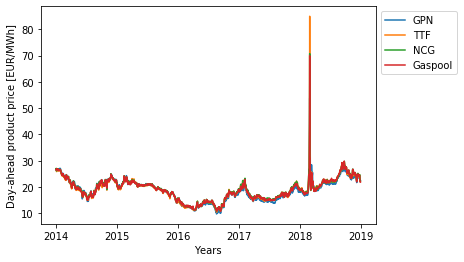

In [11]:
plt.plot(market_data.loc['2014':'2018'])
plt.xlabel('Years')
plt.ylabel('Day-ahead product price [EUR/MWh]')
plt.legend(market_data.columns, bbox_to_anchor=(1, 1))

In [12]:
market_data = market_data['GPN']

In [13]:
data_since = '2014-01-01'
data_till = '2016-12-31'
forecasting_since = '2017-01-01'
forecasting_till = '2017-04-01'

In [14]:
data_since = pd.to_datetime(data_since)
data_till = pd.to_datetime(data_till)
forecasting_since = pd.to_datetime(forecasting_since)
forecasting_till = pd.to_datetime(forecasting_till)

In [15]:
series = market_data.loc['2012':'2019']


In [16]:
series.head()

2012-01-01    22.57
2012-01-02    22.97
2012-01-03    22.79
2012-01-04    21.88
2012-01-05    21.80
Freq: D, Name: GPN, dtype: float64

## Prophet

In [17]:
from fbprophet import Prophet

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [18]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [19]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))

In [20]:
def plot_mean_and_CI(mean, lb, ub, color_mean=None, color_shading=None):
    # plot the shaded range of the confidence intervals
    plt.fill_between(range(mean.shape[0]), ub, lb,
                     color=color_shading, alpha=.5)
    # plot the mean on top
    plt.plot(mean, color_mean)

### Holidays

In [21]:
from datetime import date
import holidays

In [22]:
dk_holidays = holidays.Denmark()

In [23]:
holidays_analysed = []
for year in range(2012,2020):
    for date, name in sorted(holidays.DK(years=year).items()):
        holidays_analysed.append((date, name))

In [24]:
holidays_analysed = pd.DataFrame(holidays_analysed)
holidays_analysed.columns = ['ds', 'holiday']
holidays_analysed

,ds,holiday
0,2012-01-01,Nytårsdag
1,2012-04-01,Palmesøndag
2,2012-04-05,Skærtorsdag
3,2012-04-06,Langfredag
4,2012-04-08,Påskedag
...,...,...
91,2019-05-30,Kristi himmelfartsdag
92,2019-06-09,Pinsedag
93,2019-06-10,Anden pinsedag
94,2019-12-25,Juledag


In [25]:
holidays_analysed.holiday.unique()

array(['Nytårsdag', 'Palmesøndag', 'Skærtorsdag', 'Langfredag',
       'Påskedag', 'Anden påskedag', 'Store bededag',
       'Kristi himmelfartsdag', 'Pinsedag', 'Anden pinsedag', 'Juledag',
       'Anden juledag'], dtype=object)

## Preprocessing

In [26]:
gas_price_prophet = pd.DataFrame(series)
gas_price_prophet['Time'] = gas_price_prophet.index
gas_price_prophet = gas_price_prophet.reset_index()
gas_price_prophet = gas_price_prophet[['GPN', 'Time']]
gas_price_prophet.columns = ['y', 'ds']
gas_price_prophet.head()

,y,ds
0,22.57,2012-01-01
1,22.97,2012-01-02
2,22.79,2012-01-03
3,21.88,2012-01-04
4,21.80,2012-01-05


In [27]:
gas_price_prophet.loc[(gas_price_prophet['ds'] >= '2013-03-20') & (gas_price_prophet['ds'] <= '2013-03-30'), 'y'] = None
gas_price_prophet.loc[(gas_price_prophet['ds'] >= '2018-02-28') & (gas_price_prophet['ds'] <= '2018-03-05'), 'y'] = None

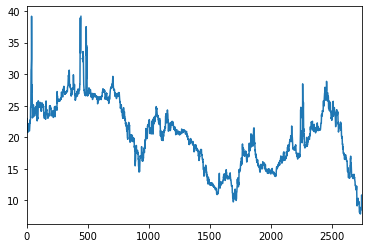

In [28]:
gas_price_prophet.y.plot()

In [37]:
data_since = '2012-05-01'
data_till = '2016-08-31'
forecasting_since = '2016-09-01'
forecasting_till = '2017-04-30'
two_years_before = '2014-09-01'

In [38]:
# Creating training dataset
train_df = gas_price_prophet[(gas_price_prophet['ds'] >= data_since) & (gas_price_prophet['ds'] <= data_till)]
test_dt = gas_price_prophet[(gas_price_prophet['ds'] >= forecasting_since) & (gas_price_prophet['ds'] <= forecasting_till)]

## Modelling

In [39]:
m = Prophet(yearly_seasonality=True, weekly_seasonality=True, growth='linear', holidays=holidays_analysed)
m.fit(train_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [40]:
model_fit = m.make_future_dataframe(periods = ((pd.to_datetime(forecasting_till) - pd.to_datetime(forecasting_since)).days + 1))
test_y = m.predict(model_fit)

In [41]:
y_true = series.loc[forecasting_since:forecasting_till]

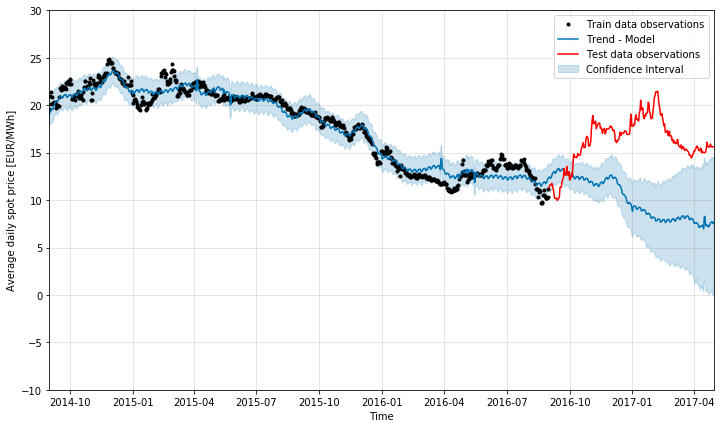

In [42]:
m.plot(test_y)
plt.plot(y_true, color = 'red')
plt.ylabel('Average daily spot price [EUR/MWh]')
plt.xlabel('Time')
plt.xlim((pd.to_datetime(two_years_before), pd.to_datetime(forecasting_till)))
plt.ylim((-10,30))
plt.legend(['Train data observations', 'Trend - Model', 'Test data observations', 'Confidence Interval'])


In [35]:
print('MAE =', mean_absolute_error(y_true, test_y['yhat'][(test_y['ds'] >= forecasting_since) & (test_y['ds'] <= forecasting_till)]))
print('MAPE =', mean_absolute_percentage_error(y_true, test_y['yhat'][(test_y['ds'] >= forecasting_since) & (test_y['ds'] <= forecasting_till)]))
print('RMSE =', mean_squared_error(y_true, test_y['yhat'][(test_y['ds'] >= forecasting_since) & (test_y['ds'] <= forecasting_till)], squared = False))


MAE = 7.945130461909085
MAPE = 0.47608174283212107
RMSE = 9.326344853604725


In [101]:
def plot_mean_and_CI(mean, lb, ub, color_mean=None, color_shading=None):
    # plot the shaded range of the confidence intervals
    plt.fill_between(range(mean.shape[0]), ub, lb,
                     color=color_shading, alpha=.5)
    # plot the mean on top
    plt.plot(mean, color_mean)

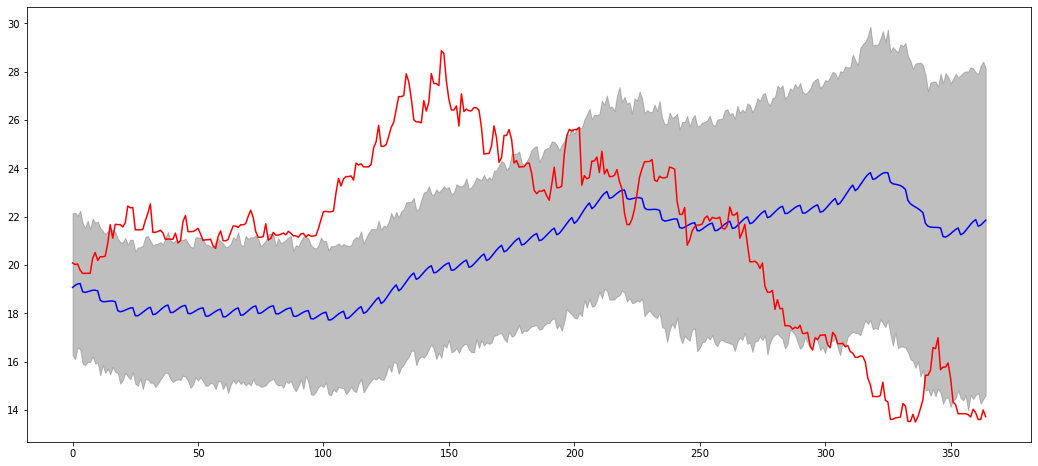

In [104]:
y_pred = test_y[(test_y['ds'] >= forecasting_since) & (test_y['ds'] <= forecasting_till)].reset_index()
plot_mean_and_CI(y_pred['yhat'], y_pred['yhat_lower'], y_pred['yhat_upper'], color_mean = 'blue', color_shading = 'grey')
plt.plot(series.loc[forecasting_since:forecasting_till].values, color = 'red')


In [98]:
y_pred

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
2312,2018-05-01,19.074800,16.272682,22.144386,19.074800,19.074800,-0.006060,-0.006060,-0.006060,-0.002434,-0.002434,-0.002434,-0.003626,-0.003626,-0.003626,0.0,0.0,0.0,19.068741
2313,2018-05-02,19.082475,16.098060,22.163670,19.082475,19.082475,0.071678,0.071678,0.071678,0.076368,0.076368,0.076368,-0.004689,-0.004689,-0.004689,0.0,0.0,0.0,19.154154
2314,2018-05-03,19.090150,16.584558,22.032335,19.090150,19.090150,0.121350,0.121350,0.121350,0.136374,0.136374,0.136374,-0.015024,-0.015024,-0.015024,0.0,0.0,0.0,19.211500
2315,2018-05-04,19.097825,16.515987,22.241172,19.097825,19.097825,0.133956,0.133956,0.133956,0.168617,0.168617,0.168617,-0.034661,-0.034661,-0.034661,0.0,0.0,0.0,19.231781
2316,2018-05-05,19.105500,15.919085,21.723445,19.105500,19.105500,-0.213812,-0.213812,-0.213812,-0.150401,-0.150401,-0.150401,-0.063411,-0.063411,-0.063411,0.0,0.0,0.0,18.891688
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2672,2019-04-26,21.837755,14.617237,27.978380,15.032353,27.605004,0.038309,0.038309,0.038309,0.168617,0.168617,0.168617,-0.130308,-0.130308,-0.130308,0.0,0.0,0.0,21.876065
2673,2019-04-27,21.845430,14.698399,27.893818,15.005687,27.648225,-0.242587,-0.242587,-0.242587,-0.150401,-0.150401,-0.150401,-0.092186,-0.092186,-0.092186,0.0,0.0,0.0,21.602844
2674,2019-04-28,21.853105,14.259226,28.240124,14.979022,27.683610,-0.208035,-0.208035,-0.208035,-0.148541,-0.148541,-0.148541,-0.059494,-0.059494,-0.059494,0.0,0.0,0.0,21.645070
2675,2019-04-29,21.860780,14.452872,28.416062,14.952356,27.712538,-0.113394,-0.113394,-0.113394,-0.079984,-0.079984,-0.079984,-0.033410,-0.033410,-0.033410,0.0,0.0,0.0,21.747387


## TSA

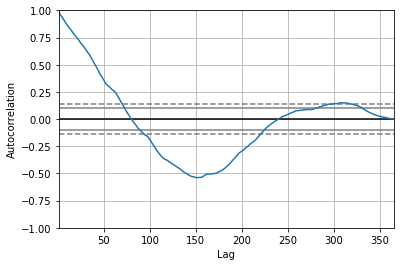

In [17]:
pd.plotting.autocorrelation_plot(series)

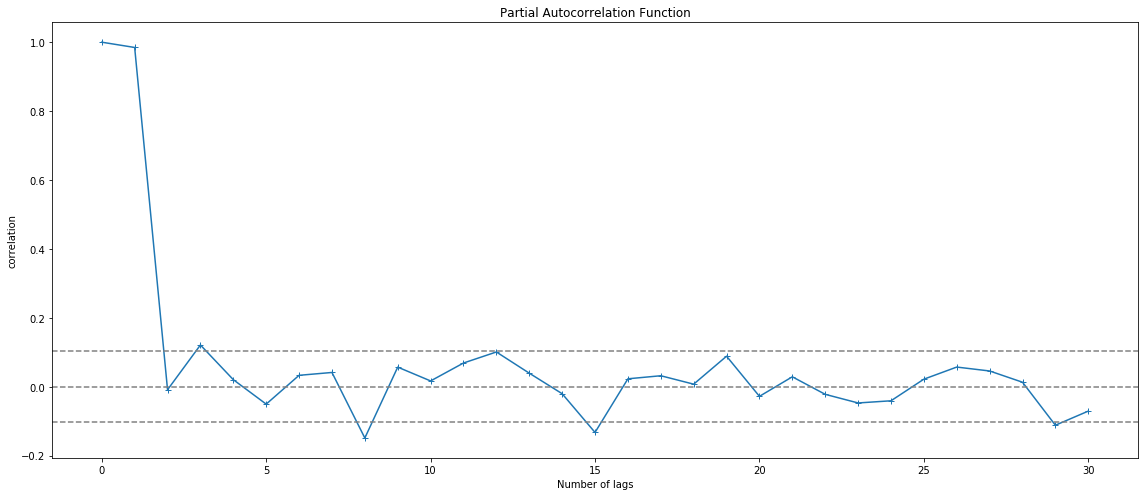

In [18]:
#calling partial correlation function
lag_pacf = pacf(series, nlags=30, method='ols')
#Plot PACF:
plt.figure(figsize=(16, 7))
plt.plot(lag_pacf,marker='+')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(series)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(series)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.xlabel('Number of lags')
plt.ylabel('correlation')
plt.tight_layout()

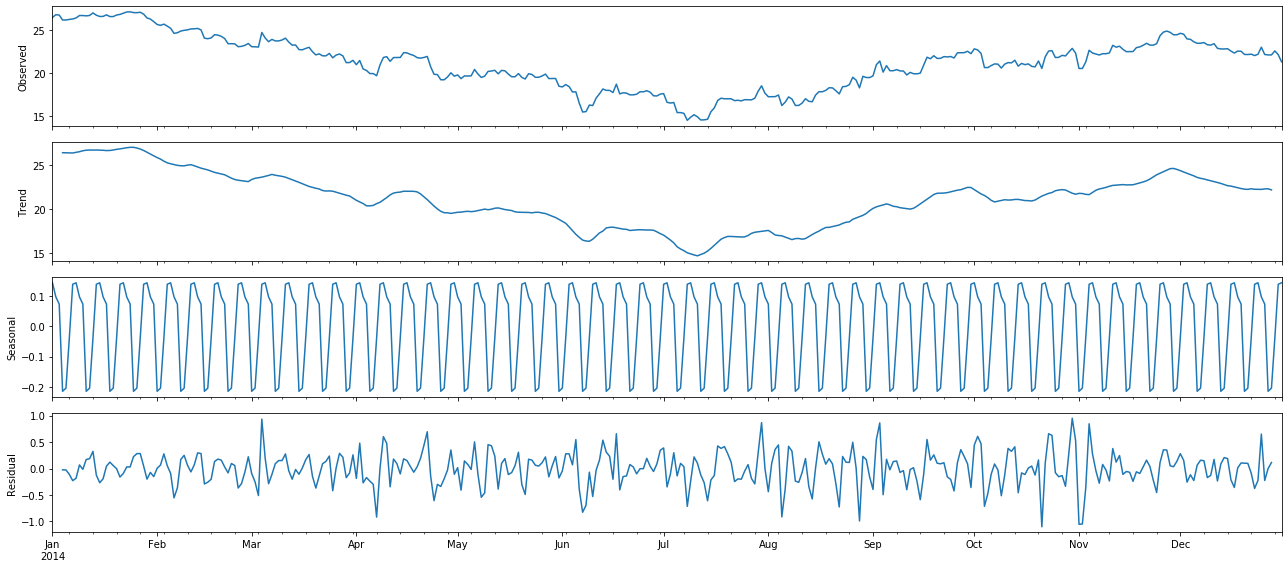

In [18]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(series, model='additive')
fig = decomposition.plot()
plt.show()

In [19]:
p = d = q = range(2, 4)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]


In [20]:
grid_search_TSA = False

In [21]:
if grid_search_TSA:
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(series,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
                results = mod.fit()
                print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue

In [22]:
# fit model
model = sm.tsa.statespace.SARIMAX(series,
                                  order=(3, 1, 3),
                                  seasonal_order=(2, 2, 3, 7),
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)
model_fit = model.fit(disp=0)
print(model_fit.summary())


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                 Statespace Model Results                                
Dep. Variable:                               GPN   No. Observations:                  365
Model:             SARIMAX(3, 1, 3)x(2, 2, 3, 7)   Log Likelihood                -229.574
Date:                           Tue, 24 Sep 2019   AIC                            483.148
Time:                                   14:19:43   BIC                            528.554
Sample:                               01-01-2014   HQIC                           501.269
                                    - 12-31-2014                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5894      0.556      1.060      0.289      -0.501       1.680
ar.L2         -0.2628      0.504     -0.521

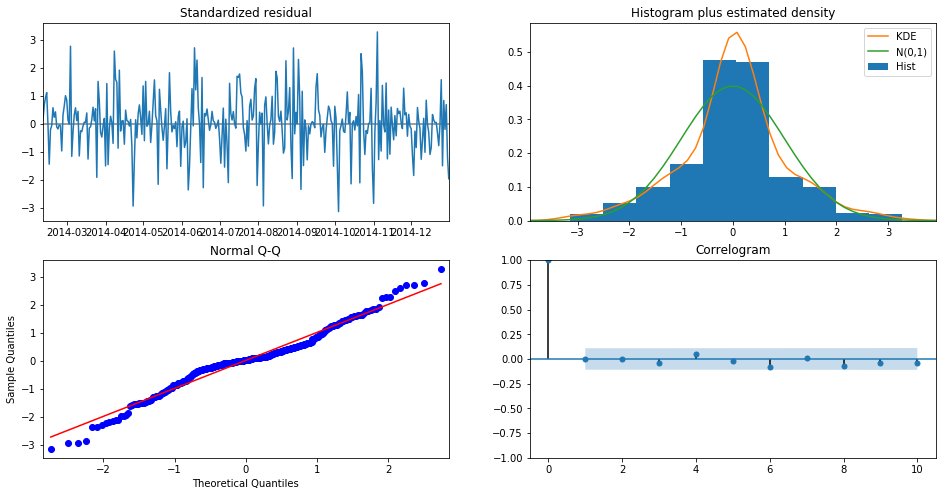

In [23]:
model_fit.plot_diagnostics(figsize=(16, 8))
plt.show()

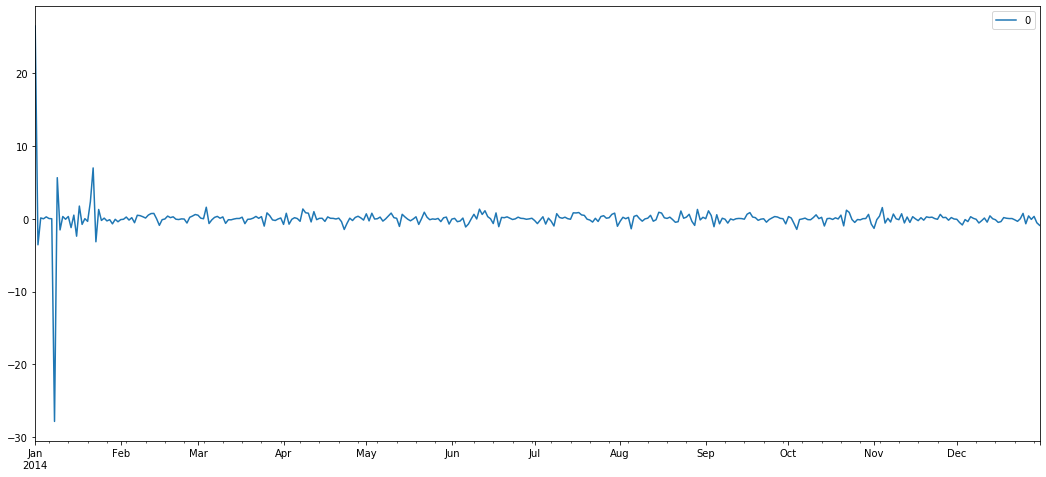

In [24]:
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()

                0
count  365.000000
mean     0.018496
std      2.146262
min    -27.836775
25%     -0.192603
50%      0.007395
75%      0.242021
max     26.440000


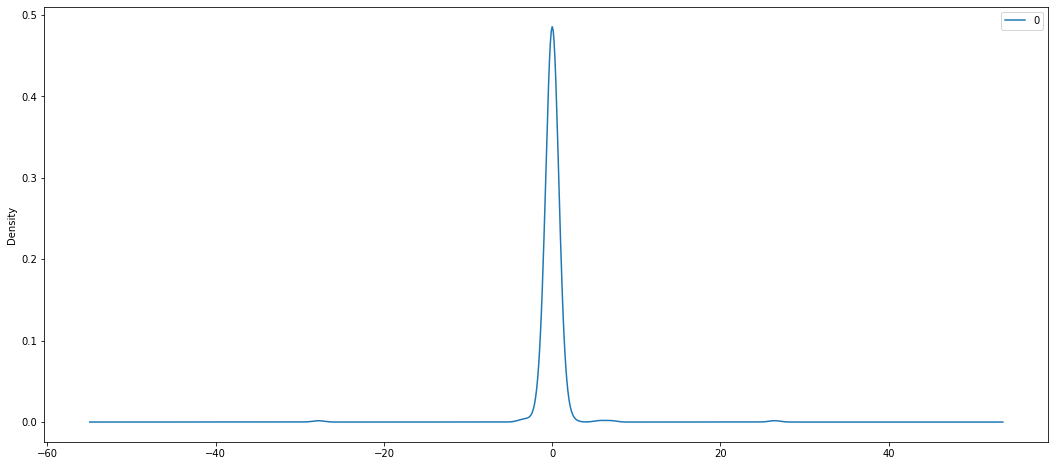

In [25]:
# density plot of the residual error values
residuals.plot(kind='kde')
print(residuals.describe())

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:336: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


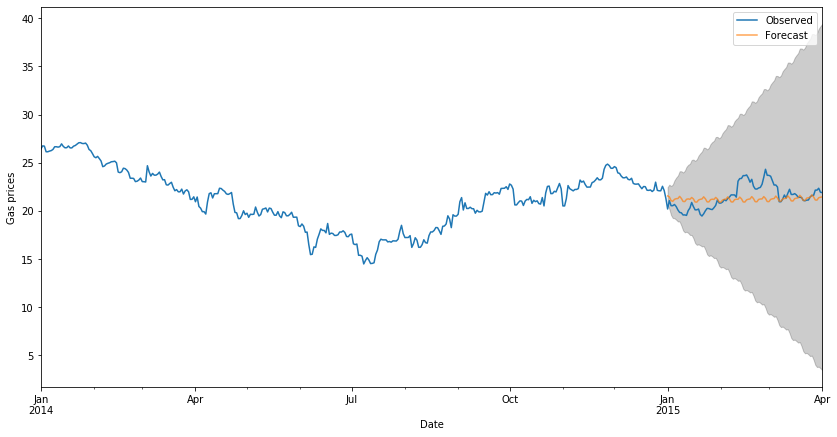

In [26]:
pred = model_fit.get_prediction(start=forecasting_since, end=forecasting_till, dynamic=False)
pred_ci = pred.conf_int()
ax = market_data[data_since:forecasting_till].plot(label='Observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Gas prices')
plt.legend()
plt.show()

In [27]:
y_forecasted = pred.predicted_mean
y_truth = market_data['2013-01-01':'2013-04-01']
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is nan
The Root Mean Squared Error of our forecasts is nan


## Analysis of seasonality

In [16]:
from pylab import rcParams

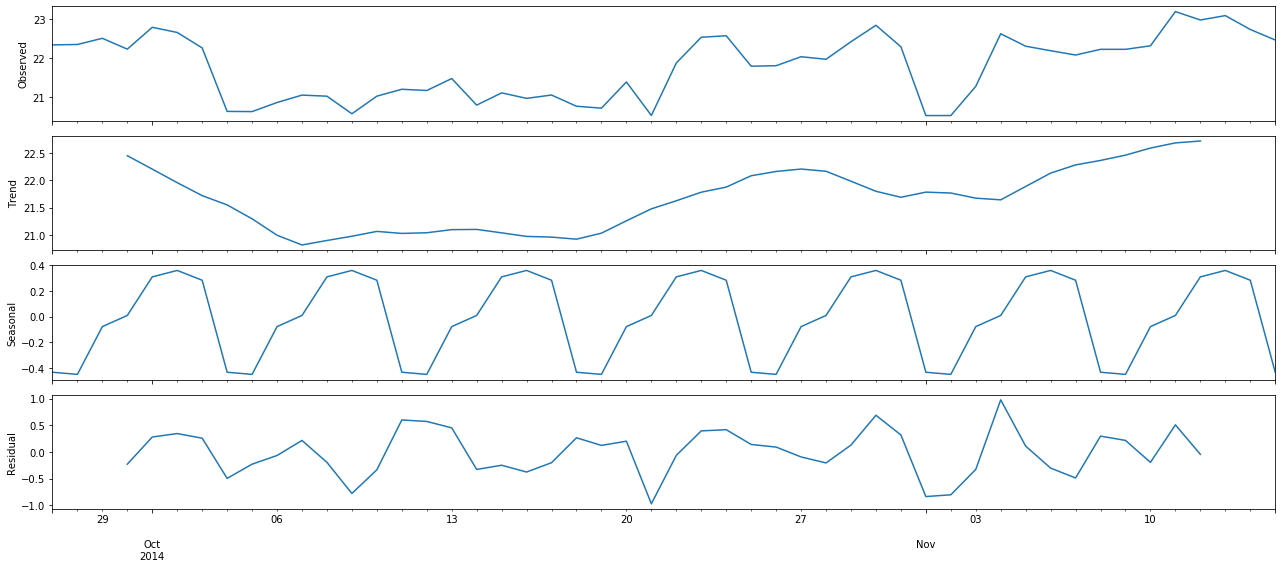

In [21]:
rcParams['figure.figsize'] = 18, 8
decomposition_weekly = sm.tsa.seasonal_decompose(series.iloc[1000:1050], model='additive')
fig = decomposition_weekly.plot()
plt.show()

In [27]:
weekly_gas_price = pd.DataFrame(series)
weekly_gas_price['Time'] = weekly_gas_price.index
weekly_gas_price = weekly_gas_price.reset_index()
weekly_gas_price = weekly_gas_price[['GPN', 'Time']]
weekly_gas_price.tail()

,GPN,Time
2744,8.491,2019-07-07
2745,8.764,2019-07-08
2746,9.900,2019-07-09
2747,10.831,2019-07-10
2748,10.135,2019-07-11


In [28]:
weekly_gas_price = weekly_gas_price.resample('W-Mon', on='Time')['GPN'].mean()

In [29]:
weekly_gas_price.head()

Time
2012-01-02    22.770000
2012-01-09    21.678571
2012-01-16    22.050000
2012-01-23    21.255714
2012-01-30    22.440000
Freq: W-MON, Name: GPN, dtype: float64

Text(0, 0.5, 'Weekly average price [EUR/MWh]')

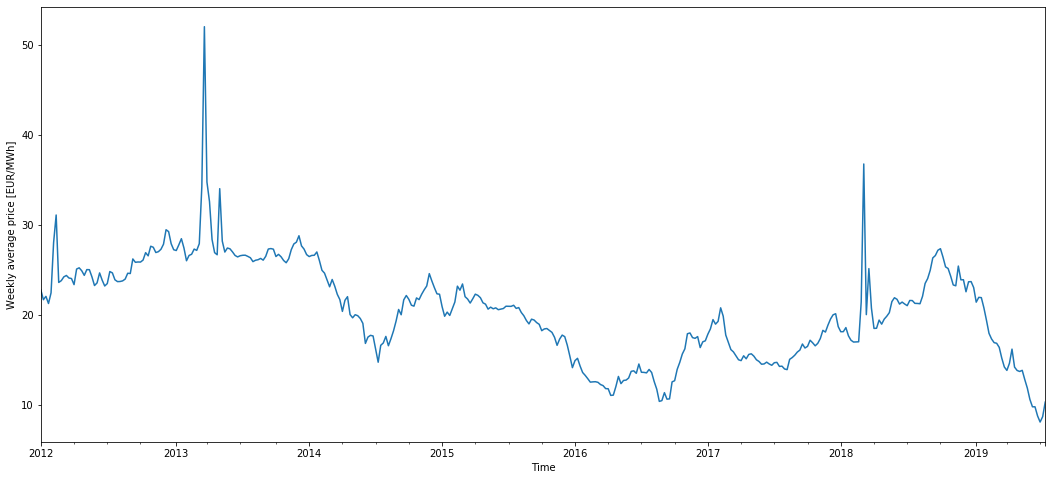

In [31]:
weekly_gas_price.plot()
plt.ylabel('Weekly average price [EUR/MWh]')

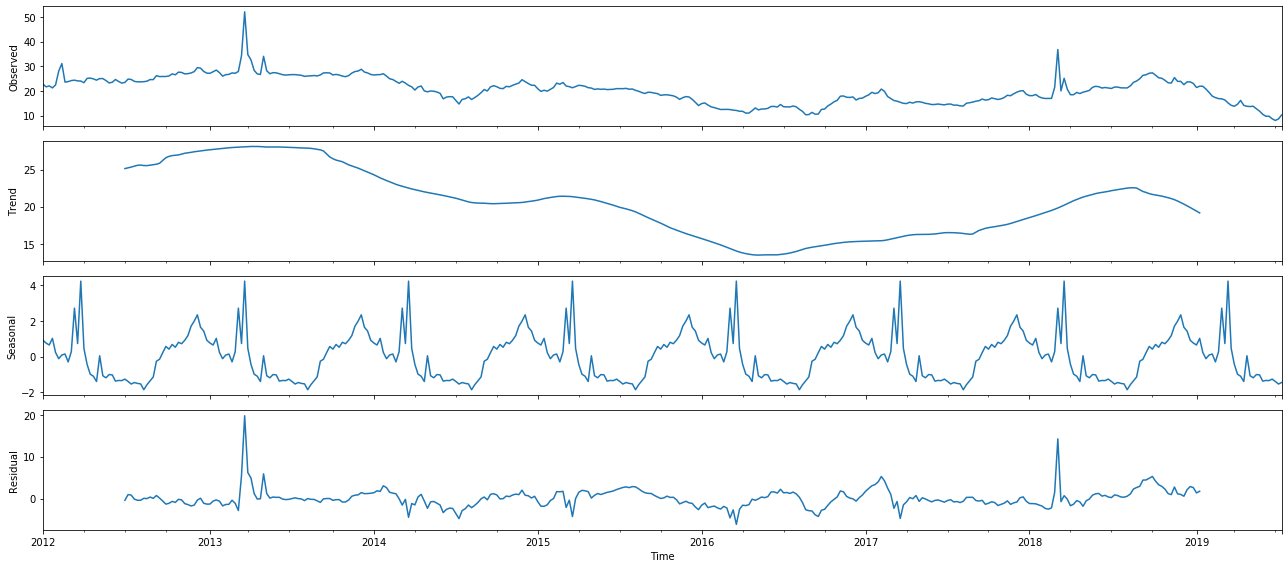

In [32]:
rcParams['figure.figsize'] = 18, 8
decomposition_yearly = sm.tsa.seasonal_decompose(weekly_gas_price, model='additive')
fig = decomposition_yearly.plot()
plt.show()

Observations: 1410
Training Observations: 705
Testing Observations: 705
Observations: 2115
Training Observations: 1410
Testing Observations: 705
Observations: 2820
Training Observations: 2115
Testing Observations: 705


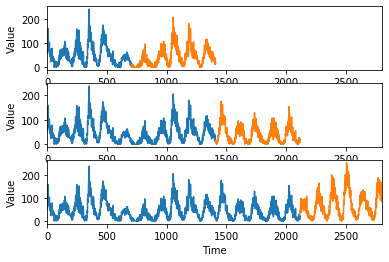

In [29]:
from pandas import read_csv
from sklearn.model_selection import TimeSeriesSplit
from matplotlib import pyplot
series = read_csv('sunspots.csv', header=0, index_col=0)
X = series.values
splits = TimeSeriesSplit(n_splits=3)
pyplot.figure(1)
index = 1
for train_index, test_index in splits.split(X):
    train = X[train_index]
    test = X[test_index]
    print('Observations: %d' % (len(train) + len(test)))
    print('Training Observations: %d' % (len(train)))
    print('Testing Observations: %d' % (len(test)))
    pyplot.subplot(310 + index)
    pyplot.plot(train)
    pyplot.plot([None for i in train] + [x for x in test])
    pyplot.xlim((0,2800))
    pyplot.xlabel('Time')
    pyplot.ylabel('Value')
    index += 1
pyplot.show()

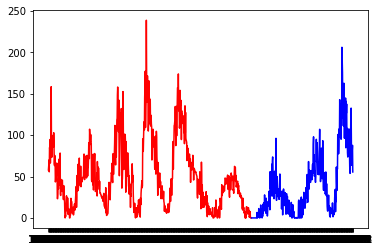

In [34]:
pyplot.plot(series.iloc[:730], color = 'red')
pyplot.plot(series.iloc[730:730+365], color = 'blue')
